In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pysindy as ps
# from Yukawa_SINDy import *

In [3]:
# Stuff used in Yukawa_SINDy.py
from pysindy.differentiation import FiniteDifference
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error # doesn't work, but works in the file 'aps_workshop.ipynb'. why??
from sklearn.linear_model import Lasso

# For reproducibility
np.random.seed(2738) # defined later in function

# Solver keywords
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12 # set relative tolerance
integrator_keywords['method'] = 'LSODA' # # Livermore Solver for Ordinary Differential Equations with Automatic Stiffness Adjustment
integrator_keywords['atol'] = 1e-12 # set absolute tolerance

In [4]:
# ignore warnings
# stuff to hide warnings (doesn't work)
import warnings
from copy import copy
from contextlib import contextmanager
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning

@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters

new line

# Code

In [6]:
'''
File:         Yukawa_SINDy.py
Written by:   Brooks Howe
Last updated: 2024/09/21
Description:  Python script containing functions used in
              the file 'YukawaEOM_basic.ipynb'.
'''

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps
from pysindy.differentiation import FiniteDifference
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Plotting parameters
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': (8,6)})

# create 'integrator_keywords' dict for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12 # set relative tolerance
integrator_keywords['method'] = 'LSODA' # Livermore Solver for Ordinary Differential Equations with Automatic Stiffness Adjustment
integrator_keywords['atol'] = 1e-12 # set absolute tolerance

class Simulation:
    '''
    Description: Parent class for simulation objects.
    Attributes:
        Simulation parameters
            duration: duration of simulation, positional arg
            dt: timestep, default 0.001, kwarg
            x0: initial position, default 1, kwarg
            v0: initial velocity, default 0.01, kwarg
        boolean flags:
            is_noisy: bool, is data noisy? default False
            is_subsampled: bool, is data subsampled? default False
        noise_level: standard deviation of gaussian noise added to data,
            default 0 (implying no noise)
        sample_frac: fraction of data which was subsampled,
            default 1 (implying no subsampling)
        data variables:
            t: time data, default None
            t_full: full time data (if subsampled), default None
            x: position, velocity data, default None
            x_clean: clean data (if noise added), default None
            x_fullnoisydata: full noisy data (if subsampled after 
                noise added), default None


    Methods (in the same order they are written in this class):
        add_gaussian_noise(noise_level=0.01)
            adds gaussian noise to the data with standard deviation noise_level. Does not add
            if already noisy. Moves clean data to attribute x_clean, and stores noisy data in 
            attribute x.
        delete_noise()
            deletes the noise added to the data and restores the clean data to the attribute x.
        subsample(fraction=0.1)
            subsamples the data to a fraction of the original data. If data is clean, moves to
            attribute x_clean. If data is noisy, moves to attribute x_fullnoisydata. Subsampled
            data is saved in attribute x.
        restore_data()
            restores the full, unsubsampled data to the attribute x.
        plot()
            plots the data. If clean, plots only the clean data; if noisy, plots both the clean
            and noisy data.
    '''
    ###############################################################################################
    # Class Constructor
    ###############################################################################################

    def __init__(self):
        self.duration = None
        self.dt = None
        self.x0 = None
        self.v0 = None
        self.is_noisy = False
        self.noise_level = 0
        self.is_subsampled = False
        self.sample_frac = 1

        # is this needed? maybe good for storage?
        self.t=None
        self.t_full = None
        self.x=None
        self.x_clean=None
        self.x_fullnoisydata=None

    ###############################################################################################
    # Getters and setters
    ###############################################################################################

    @property
    def duration(self):
        # print("duration getter called") # for testing
        return self._duration
    @duration.setter
    def duration(self, duration):
        # print("duration setter called") # for testing
        # if duration >= 10:
        #     raise ValueError("duration must be less than 10")
        self._duration = duration
    
    @property
    def dt(self):
        return self._dt
    @dt.setter
    def dt(self, dt):
        self._dt = dt
    
    @property
    def x0(self):
        return self._x0
    @x0.setter
    def x0(self, x0):
        self._x0 = x0
    
    @property
    def v0(self):
        return self._v0
    @v0.setter
    def v0(self, v0):
        self._v0 = v0

    # Not working for some reason:
    # @property
    # def is_noisy(self):
    #     return self._is_noisy
    
    # @is_noisy.setter
    # def noisy(self, is_noisy):
    #     self._is_noisy = is_noisy

    @property
    def noise_level(self):
        return self._noise_level
    @noise_level.setter
    def noise_level(self, noise_level):
        self._noise_level = noise_level

    @property
    def sample_frac(self):
        return self._sample_frac
    @sample_frac.setter
    def sample_frac(self, sample_frac):
        self._sample_frac = sample_frac
        
    @property
    def t(self):
        return self._t
    @t.setter
    def t(self, t):
        self._t = t

    @property
    def t_full(self):
        if self._t_full is None:
            print("t is not subsampled.")
        return self._t_full
    @t_full.setter
    def t_full(self, t_full):
        self._t_full = t_full

    @property
    def x(self):
        if self._x is None:
            print("No simulation performed. Use simulate() first.")
            return
        return self._x
    @x.setter
    def x(self, x):
        self._x = x
    
    @property
    def x_clean(self):
        if self._x_clean is None:
            print("No noise added to x, x is clean.")
        return self._x_clean
    @x_clean.setter
    def x_clean(self, x_clean):
        self._x_clean = x_clean

    @property
    def x_fullnoisydata(self):
        if self._x_fullnoisydata is None:
            print("x is not subsampled.")
        return self._x_fullnoisydata
    @x_fullnoisydata.setter
    def x_fullnoisydata(self, x_fullnoisydata):
        self._x_fullnoisydata = x_fullnoisydata

    ###############################################################################################
    # Class Methods
    ###############################################################################################

    def add_gaussian_noise(self, noise_level=0.01):
        if self.x is None:
            raise Exception("No simulation performed. Use .simulate() first.")
        if self.is_noisy:
            raise Exception("Data is already noisy, no new noise added.")
        if self.is_subsampled:
            raise Exception("Cannot add noise to subsampled data, create new sim object to add noise.")
        # Adds noise to data
        # generate noise
        dims = np.shape(self.x)
        rng = np.random.default_rng(seed=2673) # add seed number for reproducibility
        noise =  rng.normal(loc=0,scale=noise_level,size=dims)
        '''code for normalizing noise to avg dispacement/timestep
        # generate noise for position
        std_dev = (self.x[:,0].max() - self.x[:,0].min()) / self.x.shape[0] * noise_level
        x_noise =  rng.normal(loc=0,scale=std_dev,size=dims[0])
        # generate noise for velocity
        std_dev = (self.x[:,1].max() - self.x[:,1].min()) / self.x.shape[0] * noise_level
        v_noise =  rng.normal(loc=0,scale=std_dev,size=dims[0])
        noise =  np.column_stack((x_noise, v_noise))
        '''
        # add noise to data
        self.x_clean = self.x
        self.x = self.x + noise
        self.is_noisy = True
        self.noise_level = noise_level
        return self
    
    def delete_noise(self):
        if self.is_noisy:
            self.x = self.x_clean
            self.x_clean = None
            self.is_noisy = False
            self.noise_level = 0
        else:
            raise Exception("Data is already clean, no noise removed.")
        return self
    
    def subsample(self, sample_frac=0.1):
        if self.x is None:
            raise Exception("No simulation performed. Use simulate() first.")
        if self.is_subsampled:
            raise Exception("Data is already subsampled, no new subsampling performed.")
        # Subsample data
        idx = np.arange(self.x.shape[0])
        rng = np.random.default_rng(seed=2673) # add seed number for reproducibility
        ridx = rng.choice(idx, size = (int(idx.shape[0]*sample_frac)), replace=False, shuffle=False)
        ridx.sort()
        x_subsampled = self.x[ridx]
        t_subsampled = self.t[ridx]
        # save data as attributes
        if self.is_noisy:
            self.x_fullnoisydata = self.x
        else:
            self.x_clean = self.x
        self.x = x_subsampled
        self.t_full = self.t
        self.t = t_subsampled
        self.is_subsampled = True
        self.sample_frac = sample_frac
        return self
    
    def restore_data(self):
        if self.is_subsampled:
            if self.is_noisy:
                self.x = self.x_fullnoisydata
                self.x_fullnoisydata = None
            else:
                self.x = self.x_clean
                self.x_clean = None
            self.is_subsampled = False
            self.sample_frac = 1
            self.t = self.t_full
            self.t_full = None
        else:
            raise Exception("Data was not subsampled.")
        return self
    
    def plot(self):
        if self.x is None:
            raise Exception("No simulation performed. Use simulate() first.")
        labels = np.array([["noisy position", "clean position"], ["noisy velocity", "clean velocity"]])
        plt.xlabel("time (s)")
        for i in range(self.x.shape[1]):
            if self.is_noisy:
                plt.plot(self.t, self.x[:,i], label=labels[i,0])
                if self.is_subsampled:
                    plt.plot(self.t_full, self.x_clean[:,i], label=labels[i,1])
                    plt.title(f"Randomly sampled {self.sample_frac*100}% of Noisy Data")
                else:
                    plt.plot(self.t, self.x_clean[:,i], label=labels[i,1])
                    plt.title("Noisy Data")
            else:
                plt.plot(self.t, self.x[:,i], label=labels[i,1])
                if self.is_subsampled:
                    plt.title(f"Randomly sampled {self.sample_frac*100}% of Clean Data")
                else:
                    plt.title("Clean Data")
        plt.legend()


class Yukawa_simulation(Simulation):
    '''
    Description: Class for simulating the Yukawa equation of motion for a two-body system.
                 Inherits from Simulation
    Methods (in the same order they are written in this class):
        simulate(duration, dt=0.001, x0=1, v0=0.01)
            solves the Yukawa equation of motion for given parameters using solve_ivp from scipy.
            Data is stored in the attribute x.
    '''

    ###############################################################################################
    # Class Methods
    ###############################################################################################

    def simulate(self, duration, dt=0.001, x0=1.0, v0=0.01):
        # syntax: simulate(3, dt=0.001, x0=1, v0=0.01)
        # Generate measurement data
        t = np.arange(0, duration, dt)
        t_span = (t[0], t[-1])

        x0_train = [x0, v0]
        def Yukawa_EOM(t, x): return [x[1], ( 1/x[0] + 1/x[0]**2 ) * np.exp( -x[0] ) ]
        x_clean = solve_ivp(Yukawa_EOM, t_span, x0_train, t_eval=t, **integrator_keywords).y.T
        # save parameters as attributes
        self.duration = duration
        self.dt = dt
        self.x0 = x0
        self.v0 = v0
        # save data as attributes
        self.t=t
        self.x=x_clean
        return self


###############################################################################################
# SINDy functions
###############################################################################################
def set_optimizer(opt_str: str, hparam: float):
# Syntax: set_optimizer("stlsq", 0.1)
# Description: Sets the optimizer for SINDy model based on the string "opt_str"
    if opt_str=="stlsq":
        opt = ps.STLSQ(threshold=hparam,alpha=0.05,verbose=False)
        hparam_str = "threshold"
    elif opt_str=='sr3':
        opt = ps.SR3(threshold=hparam, thresholder="l1")
        hparam_str = "threshold"
    elif opt_str=='lasso':
        opt = Lasso(alpha=hparam, max_iter=20000, fit_intercept=False)
        hparam_str = "alpha"
    else:
        raise TypeError("optimizer not recognized")
    return opt, hparam_str


def generate_Yukawa_library():
    # Syntax: generate_Yukawa_library()
    # Description: Generates a library of custom functions
    # that can be used for SINDy analysis

    # Create library of coefs
    library_functions = [
        # lambda x: 1.0, get rid of this term because it is being duplicated and causing an error
        lambda x: x,
        lambda x: np.exp(-x) / x,
        lambda x: np.exp(-x) / x**2,
        lambda x: np.exp(-x) / x**3,
        lambda x: np.exp(-x) / x**4,
    ]
    library_function_names = [
        # lambda x: 1,
        lambda x: x,
        lambda x: "exp(-" + x + ") / " + x,
        lambda x: "exp(-" + x + ") / " + x + "^2",
        lambda x: "exp(-" + x + ") / " + x + "^3",
        lambda x: "exp(-" + x + ") / " + x + "^4",
    ]
    custom_library = ps.CustomLibrary(
        library_functions=library_functions, function_names=library_function_names
    )
    return custom_library


def fit_Yukawa_model(sim_obj: Yukawa_simulation,opt_str: str='stlsq', hparam: float=0.1, return_hparam_str: bool=False):
    # Syntax: fit_Yukawa_model(sim1, 'stlsq', 0.1)
    # Description: Fits SINDy model for the Yukawa equation
    # with given optimizer and hyperparameter. Optionally 
    # returns the optimizer used as a string

    # set optimizer based on input; library, feature names set for Yukawa
    custom_library = generate_Yukawa_library()
    feature_names = ["x", "v"] # feature names to position (x) and velocity (v)
    opt, hparam_str = set_optimizer(opt_str, hparam)
    
    # fit SINDy model
    model = ps.SINDy(feature_names=feature_names, optimizer=opt, feature_library=custom_library)
    model.fit(sim_obj.x, t=sim_obj.t)
    if return_hparam_str:
        return model, hparam_str
    else:
        return model

###############################################################################################
# Plotting functions
###############################################################################################
def plot_derivatives(sim_obj: Yukawa_simulation, model: ps.SINDy):
    # Syntax: plot_derivatives(sim1, model)
    # Description: Plots the predicted and computed
    # derivatives of the SINDy model

    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(sim_obj.x)

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(sim_obj.x, t=sim_obj.t)

    fig, axs = plt.subplots(sim_obj.x.shape[1], 1, sharex=True, figsize=(7, 9))
    for i in range(sim_obj.x.shape[1]):
        axs[i].plot(sim_obj.t, x_dot_test_computed[:, i], "k", label="numerical derivative")
        axs[i].plot(sim_obj.t, x_dot_test_predicted[:, i], "r--", label="model prediction")
        axs[i].legend()
        axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
    fig.show()


def plot_coefs(model: ps.SINDy, hparam=None, std_dev=None, figsize=(12,5)):
# Syntax: plot_coefs(model)
# Description: Plots bar chart of coefficient values for each feature in the model.
    
    title_str = 'Coefficient Values'
    # get coefficents and feature names
    coefs = model.coefficients().T
    coef_names = model.get_feature_names()
    # create bar plot of coefficient values
    fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)#, sharey=True)
    for i in range(coefs.shape[1]):
        axs[i].bar(coef_names, coefs[:,i])
        # axs[i].tick_params(axis='x', labelsize=14) # change label size
        # axs[i].tick_params(axis='y', labelsize=14)
        axs[i].axhline(y=0, lw=0.75, color='k')
        axs[i].set_title('(' + model.feature_names[i] + ')\' equation')
    if hparam is not None:
        title_str += "\nHyperparameter = " + str(hparam)
        # fig.suptitle('Coefficient Values\n' + 'hparam = ' + str(hparam), fontsize=16)
    if std_dev is not None:
        title_str += ", Standard deviation of noise= " + str(std_dev)

    fig.suptitle(title_str, fontsize=16)
    fig.tight_layout(pad=2.0)


def plot_coef_hist(hspace, 
                   coefs_array, 
                   feature_names=[
                                    r'$r$',
                                    r'$v$',
                                    r'$\frac{e^{-r}}{r}$',
                                    r'$\frac{e^{-v}}{v}$',
                                    r'$\frac{e^{-r}}{r^2}$',
                                    r'$\frac{e^{-v}}{v^2}$',
                                    r'$\frac{e^{-r}}{r^3}$',
                                    r'$\frac{e^{-v}}{v^3}$',
                                    r'$\frac{e^{-r}}{r^4}$',
                                    r'$\frac{e^{-v}}{v^4}$'
                                    ],
                   figsize=(15,12)):
    
    # create lists for column and row titles
    col_labels = [r'$\dot{r}$ Equation', r'$\dot{v}$ Equation']
    row_labels = feature_names
    # create array of labels for subplots
    lets = np.array(list(map(chr, range(97, 123)))).reshape((13,2))
    periods = np.full_like(lets, '.')
    labels = np.char.add(lets, periods)
    # set axis limits
    ymin = 0
    ymax = 2
    xmin = min(hspace) - 0.05
    if xmin <= 0:
        xmin = 0
    xmax = max(hspace)
    # plot coefficients as threshold changes, label subplots
    fig, axs = plt.subplots(coefs_array.shape[1], coefs_array.shape[2],
                            figsize=figsize, sharex=True)#, sharey=True)
    for j in range(coefs_array.shape[2]):
        for i in range(coefs_array.shape[1]):
            axs[i,j].plot(hspace, coefs_array[:,i,j],lw=3)
            axs[i,j].set_ylim(ymin=ymin,ymax=ymax)
            axs[i,j].set_xlim(xmin=xmin,xmax=xmax)
            axs[i,j].tick_params(axis='both', labelsize=14)
            # place a text box in upper left in axes coords
            textstr = labels[i,j]
            axs[i,j].text(xmin + 0.01, (2/3)*ymax, textstr,fontsize=14) #  transform=axs[i,j].transAxes,
    # add column and row titles, set x-axis label
    for ax, col_label in zip(axs[0], col_labels): # code from https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
        ax.set_title(col_label,fontsize=18)
    for ax in axs[-1]:
        ax.set_xlabel('Threshold',fontsize=18)
    for ax, row_label in zip(axs[:,0], row_labels): 
        ax.set_ylabel(row_label, rotation=0, loc='bottom', labelpad=50, fontsize=18)

    fig.tight_layout()


def plot_complexity(complexity, hparams, first, last, step):
    ticklist = np.arange(first, last+step, step)
    # while len(ticklist) > 10:
    #     ticklist = ticklist[0::2] # slice list by taking every other element
        # the below does the same thing (maybe?) as the above but with more lines of code
        # step = step*2
        # ticklist = np.arange(first, last+step, step)
    # ticklist = np.append(ticklist, last) # doesn't line up with pattern
    plt.figure()
    plt.xlabel("Threshold Value")
    plt.ylabel("Number of terms")
    # plt.xticks(ticklist)
    ymax = np.max(complexity)
    plt.yticks(np.arange(0, ymax+1, 2))
    plt.plot(hparams, complexity, '.')


def plot_pareto(train_sim: Yukawa_simulation, test_sim: Yukawa_simulation, threshold_scan, plot_prediction: bool = False):
    # calculate x_dot with finite differences from clean test trajectory
    fd = FiniteDifference()
    xdot_test = fd._differentiate(test_sim.x, test_sim.t)

    # create empty list to store rmse values
    rmse_values = []
    for threshold in threshold_scan:
        # fit SINDy model to noisy data
        model = fit_Yukawa_model(train_sim, opt_str="stlsq", hparam=threshold)
        # predict with test trajectory
        xdot_test_predicted = model.predict(test_sim.x, test_sim.t)
        # compare trajectory predicted by SINDy model with clean test trajectory
        rmse = mean_squared_error(xdot_test, xdot_test_predicted, squared=False)
        rmse_values.append(rmse)

    if plot_prediction:
        _, ax = plt.subplots()
        ax.plot(test_sim.t, xdot_test)
        ax.plot(test_sim.t, xdot_test_predicted, linestyle='--')

    _, ax = plt.subplots(figsize=(5, 5))
    ax.plot(threshold_scan, rmse_values)
    ax.set(xlabel="Threshold", ylabel="RMSE")
    ax.set_ylim(ymin=0, ymax=5)


###############################################################################################
# MAIN FUNCTIONS
###############################################################################################
def explore_thresholds(sim_obj: Yukawa_simulation,
                       first, last, step,
                       verbose=False, plot=False,
                       opt_str="stlsq",
                       feature_names=None):
# Syntax: explore_thresholds(sim1, 0.0, 2.0, 0.1)
# Description: fits a SINDy model for thresholds in the parameter space provided
# by the arguments, then plots number of terms vs. threshold used.

    # create arrays to store complexity, hyperparameters
    # feature_names = ['x', 'v']
    complexity = np.array([])
    hspace = np.arange(first, last+step, step)

    coefs = np.empty((0,10,2))
    
    # Identify optimizer being used
    if verbose:
        print('optimizer:', opt_str)
        print('Std. dev. of noise:', sim_obj.noise_level)
        print('------------------------------')
    
    # scan through different hyperparameters
    for hparam in hspace:
        noisymodel, hparam_str = fit_Yukawa_model(sim_obj, opt_str=opt_str, hparam=hparam, return_hparam_str=True)
        new_coefs = noisymodel.coefficients().T # extract coefficient array from model
        new_coefs = new_coefs[np.newaxis, ...] # resize to append
        coefs = np.append(coefs, new_coefs, axis=0) # append to 'coefs' array
        complexity = np.append(complexity,noisymodel.complexity)
        if verbose:
            print(hparam_str, '=', round(hparam,3))
            noisymodel.print()
            print()
        # if plot:
        #     feature_names = noisymodel.get_feature_names()
        #     plot_coefs(noisymodel,hparam=round(hparam,3),std_dev=round(sim_obj.noise_level, 4))

        # commented this out because there have been some local minima which are < model.complexity
        # stop the loop if noisy model complexity is less than model complexity - 1

        # if noisymodel.complexity <= model.complexity-1:
        #     break
    # ensure that the complexity array is the same size as the hspace array
    hspace.resize(complexity.shape)
    # take absolute values of all coefs
    coefs = np.abs(coefs)

    if plot:
        if feature_names is None:
            # feature_names = noisymodel.get_feature_names()
            latex_feature_names = [
            r'$r$',
            r'$v$',
            r'$\frac{e^{-r}}{r}$',
            r'$\frac{e^{-v}}{v}$',
            r'$\frac{e^{-r}}{r^2}$',
            r'$\frac{e^{-v}}{v^2}$',
            r'$\frac{e^{-r}}{r^3}$',
            r'$\frac{e^{-v}}{v^3}$',
            r'$\frac{e^{-r}}{r^4}$',
            r'$\frac{e^{-v}}{v^4}$'
            ]
            feature_names = latex_feature_names
        plot_complexity(complexity, hspace, first, last, step)
        plot_coef_hist(hspace, coefs, feature_names=feature_names)
    
    # return complexity, hspace, coefs
    return


def explore_noises(sim_obj: Yukawa_simulation,
                   first, last, step, 
                   verbose=False, plot=False,
                   hparam = 0.1,
                   opt_str="stlsq",
                   ):
    # create array of noises to try
    noisespace = np.arange(first, last+step, step)
    # print optimizer, hparam if desired
    if verbose:
        print('optimizer:', opt_str)
        print('hparam =', hparam)
        print('----------------------------')
    # scan through different noise levels and fit SINDy model for each one
    for noise in noisespace:
        # delete noise if any
        if sim_obj.is_noisy:
            sim_obj.delete_noise()
        # add noise with current noise level and fit
        sim_obj.add_gaussian_noise(std_dev=noise)
        noisymodel = fit_Yukawa_model(sim_obj, opt_str=opt_str, hparam=hparam)
        # print model, if desired
        if verbose:
            print('standard deviation =', round(noise,4))
            noisymodel.print()
            print()
        # plot model coefs, if desired
        if plot:
            plot_coefs(noisymodel,hparam=round(hparam,3),std_dev=round(noise,4))

# Yukawa equation of motion

## Demonstration of `Yukawa_simulation` class:

We have defined a python object class which will simulate this physical system. Instantiate an instance of `Yukawa_simulation` in order to generate data. Use the `.simulate()` method to simulate, the first argument is the duration of simulation in seconds. Use the `.plot()` method to view the 

In [ ]:
example_sim = Yukawa_simulation()
example_sim.simulate(3)#, 0.001, 1, 0.01) # all default values
example_sim.plot()

Check if the simulation has had noise added to it using the `is_noisy` attribute.

In [ ]:
example_sim.is_noisy

Add gaussian-distributed noise to the data by using the `.add_gaussian_noise()` method. Default noise standard deviation is $1\%$.

In [ ]:
example_sim.add_gaussian_noise()
example_sim.plot()

Change the noise level by first deleting any noise which was already added using the `.delete_noise()` method. 

In [ ]:
example_sim.delete_noise()
example_sim.plot()

Then, add different noise level by entering desired standard deviation as the first argument of the `.add_gaussian_noise()` method.

In [ ]:
example_sim.add_gaussian_noise(0.05)
example_sim.plot()

Check standard deviation of added noise with the `noise_level` attribute.

In [ ]:
example_sim.noise_level

Subsample the noisy (or clean) data using the `.subsample()` method. Randomly samples $10\%$ of data by default:

In [ ]:
example_sim.subsample()
example_sim.plot()

To restore the full data, use the `.restore_data()` method.

In [ ]:
example_sim.restore_data()
example_sim.plot()

Note: the program will not add noise to subsampled, clean data:

In [ ]:
example_sim.delete_noise()
example_sim.subsample()
example_sim.add_gaussian_noise()

All data is stored in the 

In [ ]:
# Deprecated code:

# # x is a two-column vector, first column (x[0]) is position, second column (x[1]) is velocity
# # Normalized Yukawa EOM, call all constants 1
# def Yukawa_EOM(t, x): return [x[1], ( 1/x[0] + 1/x[0]**2 ) * np.exp( -x[0] ) ]

# def simulate_Yukawa(duration, dt=0.001, x0=1, v0=0.01, integrator_keywords=integrator_keywords):
#     # Generate measurement data
#     t_train = np.arange(0, duration, dt)
#     t_train_span = (t_train[0], t_train[-1])

#     x0_train = [x0, v0]
#     x_clean = solve_ivp(Yukawa_EOM, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T
#     return t_train, x_clean

# def plot_position_and_velocity(t_train, x_clean):
#     plt.xlabel("time (a. u.)")
#     plt.plot(t_train, x_clean[:,0], label='position')
#     plt.plot(t_train, x_clean[:,1], 'r', label='velocity')
#     plt.legend()
#     plt.show()

## Fitting a SINDy model to clean data

We will begin looking at a dusty-plasma-relevant system and trying to use SINDy to deduce the equations of motion directly from simulated data. We will begin by using clean data with no noise added, followed by adding Gaussian-distributed noise to the data to test the robustness of the method in the specific case of two particles which interact purely with the Yukawa potential.

We will simulate a two-particle system which evolves according to the Yukawa equations of motion,

$\frac{dx}{dt} = v$

$\frac{dv}{dt} = \left( \frac{1}{x} + \frac{1}{x^2} \right) e^{-x} $,

where $x$ is the interparticle separation. We will begin by generating some data:

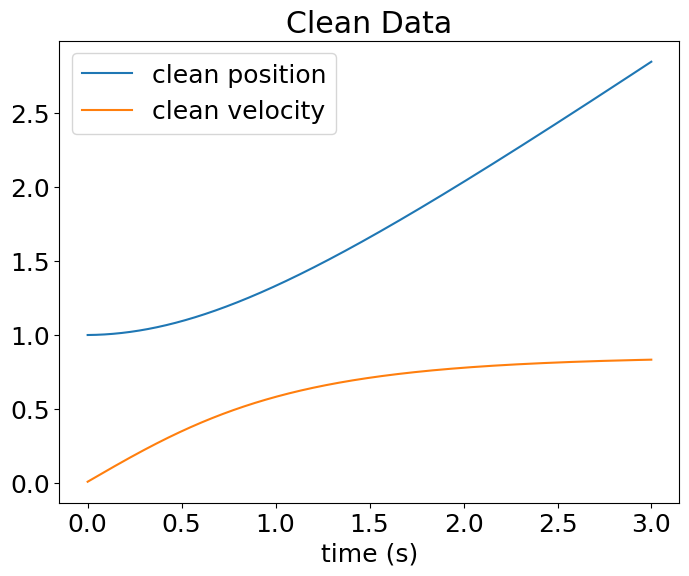

In [10]:
sim1 = Yukawa_simulation()
sim1.simulate(3)
sim1.plot()

Try with sort of a stupid library of coefs that I know will work. Will try with:

$\begin{pmatrix}
    \vert & \vert & \vert & \vert & & \vert & \vert \\
    x & v & \frac{1}{x}e^{-x} & \frac{1}{v}e^{-v} & \dots & \frac{1}{x^4}e^{-x} & \frac{1}{v^4}e^{-v} \\
    \vert & \vert & \vert & \vert & & \vert & \vert
\end{pmatrix}$

In [11]:
# Fit SINDy model with custom library:
clean_model = fit_Yukawa_model(sim1,hparam=0)
clean_model.print()

(x)' = 1.000 v
(v)' = 1.000 exp(-x) / x + 1.000 exp(-x) / x^2


In [12]:
clean_model.get_feature_names()

['x',
 'v',
 'exp(-x) / x',
 'exp(-v) / v',
 'exp(-x) / x^2',
 'exp(-v) / v^2',
 'exp(-x) / x^3',
 'exp(-v) / v^3',
 'exp(-x) / x^4',
 'exp(-v) / v^4']

Let's find exactly when, as we scan through threshold values, the SINDy model converges to the correct model.

In [ ]:
explore_thresholds(sim1, 0.0, 0.3, 0.01, plot=True, verbose=True)

Fits perfectly! Now, let's look at the coefficient matrix and complexity as a sanity check.

In [ ]:
clean_model.coefficients().T

In [ ]:
clean_model.complexity

In [ ]:
plot_coefs(clean_model)

Score does not make sense. Need to check on this later.

In [ ]:
clean_model.score(sim1.x)

Can also plot the SINDy model predicted derivatives and compare them to the derivatives calculated from data using finite difference.

In [ ]:
plot_derivatives(sim1,clean_model)

In [ ]:
explore_thresholds(sim1, 0.0, 0.3, 0.01, plot=True,verbose=False)

In [ ]:
test_model = fit_Yukawa_model(sim1,hparam=0.01)
plot_coefs(test_model,hparam=0.01,)

### Generating a Pareto Plot

To cross-validate our model, we can look at another trajectory (different initial conditions) and check if that model does well. To begin, we simulate with initial position of 1, initial velocity of -1.

In [ ]:
test_sim = Yukawa_simulation()
test_sim.simulate(3, dt=0.001, x0=1, v0=-1)
test_sim.plot()

In [ ]:
plot_pareto(sim1.x,sim1.t,np.arange(0.0,0.1,0.01),test_sim.x,test_sim.t)

### Other optimizers

#### LASSO

In [ ]:
model_lasso = fit_Yukawa_model(sim1,opt_str='lasso',hparam=0.5)
model_lasso.print()

plot_derivatives(sim1,model_lasso)

#### SR3

In [ ]:
model_sr3 = fit_Yukawa_model(sim1,opt_str='sr3',hparam=0.1)
model_sr3.print()

plot_derivatives(sim1,model_sr3)

In [ ]:
del sim1

## Noise Robustness

Fitting a SINDy model to noisy data

We now generate noisy data with the `add_gaussian_noise` attribute of the `Yukawa_simulation` class. We will start a new instance of the class to avoid conflict with the cells above. We can plot the noisy data against the clean data to have a visual representation of it.

### `std_dev=0.001`

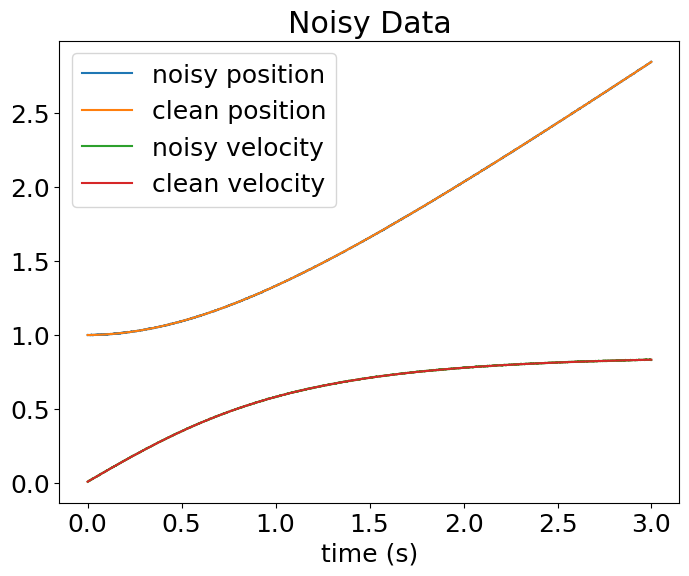

In [7]:
sim0001 = Yukawa_simulation()
sim0001.simulate(3) # simulate for 3 seconds
sim0001.add_gaussian_noise(0.001)
sim0001.plot()

Check noise level:

In [8]:
sim0001.noise_level

0.001

Model with noisy data:

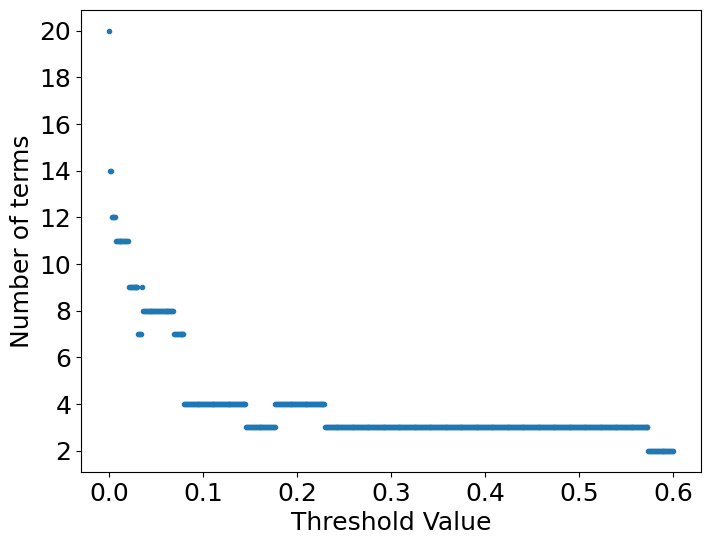

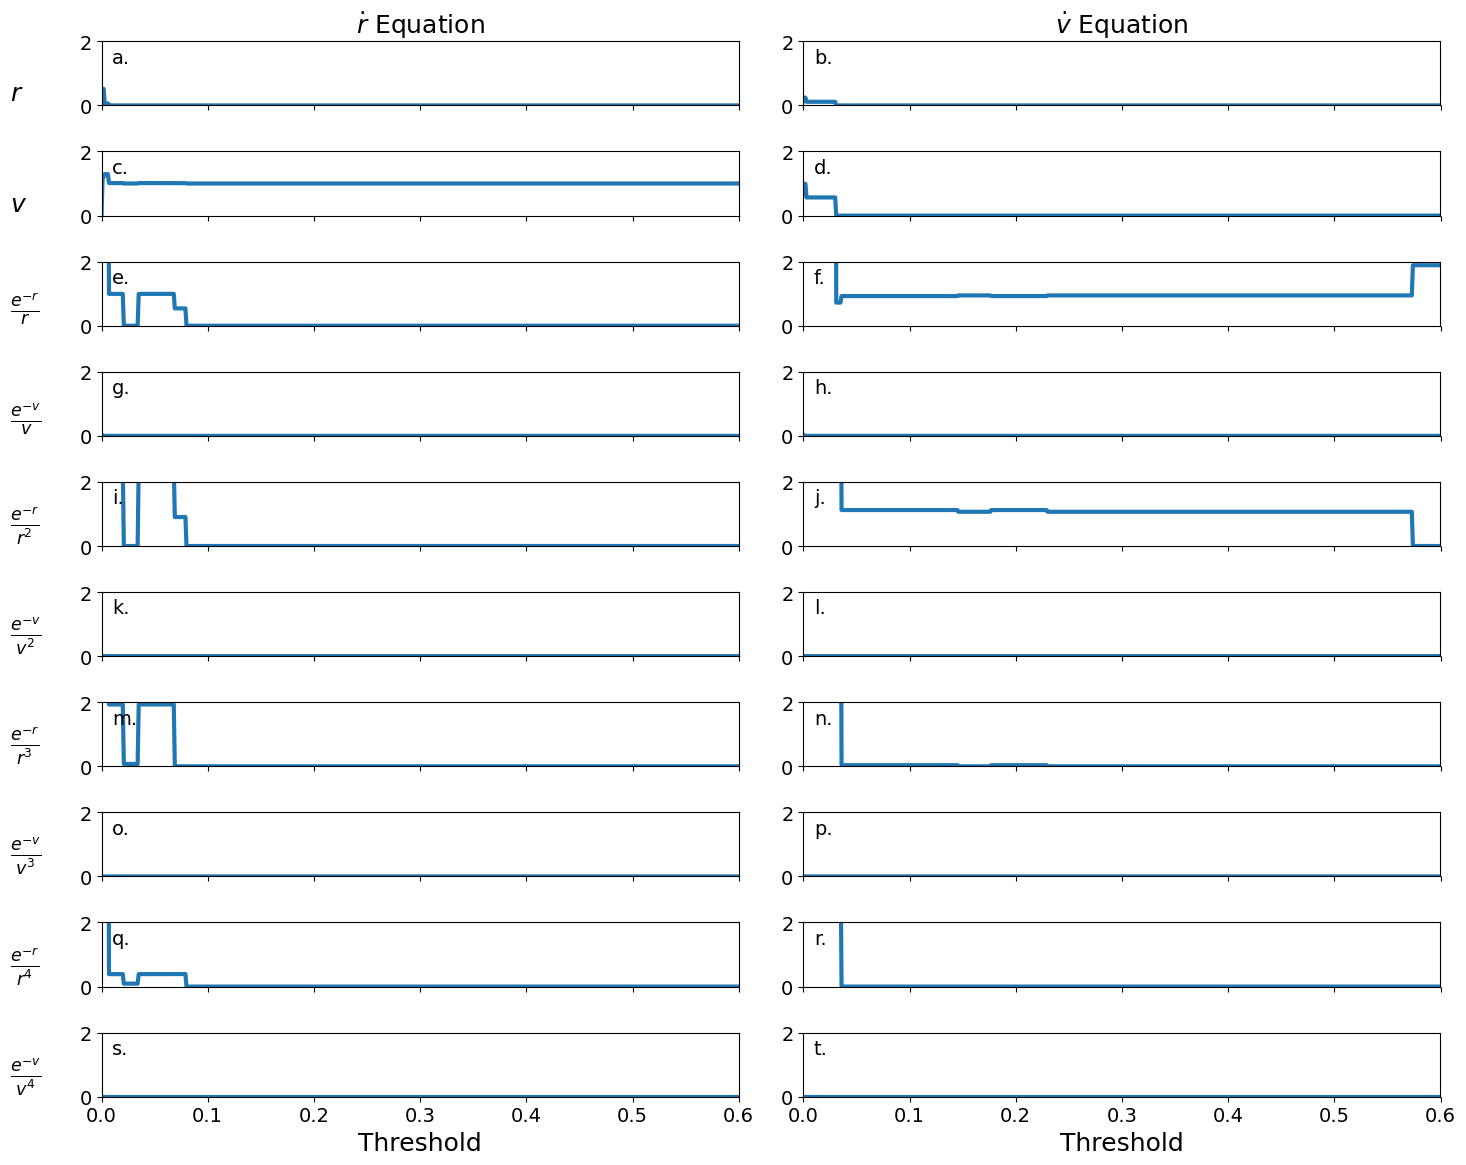

In [ ]:
# fit model and explore different thresholds
hparam_space = (0.0,0.6,0.001)
explore_thresholds(sim0001, *hparam_space, plot=True, verbose=False)

In [ ]:
for i in np.arange(0.1, 0.201, 0.001,dtype=np.longdouble):
    print('threshold =',np.round(i,3))
    fit_Yukawa_model(sim0001,opt_str='stlsq',hparam=i).print()
    print('------------------------------')
    print('\n')


### `std_dev=0.003`

In [ ]:
sim0030 = Yukawa_simulation()
sim0030.simulate(3) # simulate for 3 seconds
sim0030.add_gaussian_noise(0.003)
sim0030.plot()

In [ ]:
latex_feature_names = [
    r'$r$',
    r'$v$',
    r'$\frac{e^{-r}}{r}$',
    r'$\frac{e^{-v}}{v}$',
    r'$\frac{e^{-r}}{r^2}$',
    r'$\frac{e^{-v}}{v^2}$',
    r'$\frac{e^{-r}}{r^3}$',
    r'$\frac{e^{-v}}{v^3}$',
    r'$\frac{e^{-r}}{r^4}$',
    r'$\frac{e^{-v}}{v^4}$'
]
hparam_space = (0.0,1.0,0.01)
explore_thresholds(sim0030, *hparam_space, plot=True, verbose=False, feature_names=latex_feature_names)

something very interesting happening around `hparam=0.3`. It finds the correct *leading terms*, but then gets rid of them and goes to other terms. Let's investigate around this point more.

In [ ]:
hparam_space = (0.2,0.6,0.02)
explore_thresholds(sim0030, *hparam_space, plot=True, verbose=False)

In [ ]:
test_model = fit_Yukawa_model(sim0030, hparam=0.32)
test_model.print()
print()
test_model2 = fit_Yukawa_model(sim0030, hparam=0.42)
test_model2.print()

Let's compare a model within the local minimum to a model outside of the local minimum with the same number of terms.

In [ ]:
model0030 = fit_Yukawa_model(sim0030, hparam=0.3)
model0030.print()
print('\n')
# plot_coefs(model0030,hparam=0.3)
model0030 = fit_Yukawa_model(sim0030, hparam=0.8)
model0030.print()
# plot_coefs(model0030,hparam=0.8)

In [ ]:
for threshold in np.arange(0.2,0.401,0.001):
    print('------------------------------')
    print('\n')
    print('threshold =',np.round(threshold,3))
    fit_Yukawa_model(sim0030,hparam=threshold).print()

So we see that we have *very* different models. The `hparam=0.3` model correctly identifies the leading terms in the model, and while the `hparam=0.8` has the same number of terms it does not identify the correct leading terms. In other words, even though they have the same complexity, it's almost as if the STLSQ optimizer is converging on the wrong model over the more correct one with higher hyperparameter. Therefore, I believe this is a nonconvex problem--in the optimization, there exist local minima which may or may not identify the true model.

### `std_dev=0.01`

In [ ]:
sim0100 = Yukawa_simulation()
sim0100.simulate(3)
sim0100.add_gaussian_noise(0.01)
sim0100.plot()

In [ ]:
hparam_space = (0.0,1,0.01)
explore_thresholds(sim0100, *hparam_space, plot=True, verbose=False)

Seems to be a local minimum at around `hparam=0.32`. Investigating further:

In [ ]:
hparam_space = (0.29,0.37,0.001)
explore_thresholds(sim0100, *hparam_space, plot=True, verbose=False)

Looking at a particular model in this local min,

In [ ]:
model0010 = fit_Yukawa_model(sim0100, hparam=0.32)
model0010.print()
plot_coefs(model0010,hparam=0.32)

These models don't seem special in any particular way, other than the fact that they form a local min on the # vs threshold plot. 

There is also an interesting point around 0.53 where the correct terms appear in the $\dot{v}$ equation. Let's look at this some:

In [ ]:
hparam_space = (0.5,0.6,0.001)
explore_thresholds(sim0100, *hparam_space, plot=True, verbose=False)

A particular model from this region:

In [ ]:
model0010 = fit_Yukawa_model(sim0100, hparam=0.54)
model0010.print()

While the $\dot{v}$ equation has the correct terms here, the $\dot{x}$ equation is *completely* incorrect.

Looking into the threshold values in the range of around 0.60 to 0.80, where the algorithm seems to finally converge:

In [ ]:
# fine-tuning for finding transition point
hparam_space = (0.50,0.80,0.003)
explore_thresholds(sim0100, *hparam_space, plot=True, verbose=False)

Model with correct number of terms:

In [ ]:
model0010 = fit_Yukawa_model(sim0100, hparam=0.63)
model0010.print()

Final model:

In [ ]:
model0010 = fit_Yukawa_model(sim0100, hparam=0.75)
model0010.print()

So, the model finally converges to have the correct *leading terms*, with around `hparam=0.75`. However, the coefficient on the first order rational term is closer to 2 when it should be closer to 1.

Interestingly, the models which have the same complexity as the true model (number of terms = 3) do not capture the correct dynamics. Between `hparam=0.70` and `hparam=0.75`, we move from 3 terms to 2, and see an improvement in the model--it finds the correct leading terms at least qualitatively. Investigating this transition further,

In [ ]:
# fine-tuning for finding transition point
hparam_space = (0.70,0.75,0.001)
explore_thresholds(sim0100, *hparam_space, plot=True, verbose=False)

Aha! moving from 0.70 to 0.71 chops two terms from the $\dot{x}$ equation, and from 0.73 to 0.74 moves from identifying the wrong leading term to identifying the correct leading term in the $\dot{v}$ equation.

### `std_dev=0.03`

In [ ]:
sim0300 = Yukawa_simulation()
sim0300.simulate(3)
sim0300.add_gaussian_noise(0.03)
sim0300.plot()

In [ ]:
hparam_space = (0.0,2.0,0.01)
explore_thresholds(sim0300, *hparam_space, plot=True, verbose=True)

### `std_dev=0.05`

In [ ]:
sim0500 = Yukawa_simulation()
sim0500.simulate(3)
sim0500.add_gaussian_noise(0.05)
sim0500.plot()

In [ ]:
hparam_space = (0.0,15.1,0.1)
explore_thresholds(sim0500, *hparam_space, plot=True, verbose=True)

### `std_dev=0.1`

In [ ]:
sim1000 = Yukawa_simulation()
sim1000.simulate(3)
sim1000.add_gaussian_noise(noise_level=0.1)
sim1000.plot()

I forsee that this one will greatly benefit from sub-sampling the data, because it is so noisy.

Also, it doesn't seem like this amount of noise is very physical. Do we all mean the same thing when we say "ten percent noise?"

In [ ]:
hparam_space = (0.0,16,0.25)
explore_thresholds(sim1000, *hparam_space, plot=True, verbose=False)

In [ ]:
hparam_space = (0.0,16,2)
complexity, hparams = explore_thresholds(sim1000, *hparam_space, plot=True, verbose=False)
plot_complexity(complexity, hparams, *hparam_space)

In [ ]:
for i, threshold in enumerate(np.arange(12.0,14.1,0.1)):
    if i != 0:
        print('------------------------------')
        print('\n')
    print('threshold =',np.round(threshold,3))
    fit_Yukawa_model(sim1000,hparam=threshold).print()

### Cross-validate using different trajectory

In [ ]:
test_sim = Yukawa_simulation()
test_sim.simulate(3, dt=0.001, x0=1, v0=-1)
test_sim.plot()

In [ ]:
sim0001.plot()

In [ ]:
plot_pareto(sim0001, test_sim, np.arange(0.0,1.1,0.1))

### Subsampling

Let's try subsampling the noisy data with 10% noise added to see if the SINDy models improve.

In [ ]:
sim1000.restore_data()

In [ ]:
sim1000.subsample(0.1)
sim1000.plot()

In [ ]:
model1000 = fit_Yukawa_model(sim1000, hparam=30)
# plot_coefs(model1000)

In [ ]:
hparam_space = hparam_space = (0.0,32,4)
complexity_sub, hparams_sub = explore_thresholds(sim1000, *hparam_space, plot=False, verbose=False)
# plot_complexity(complexity, hparams, *hparam_space)

In [ ]:
sim1000.restore_data()
complexity_full, hparams_full = explore_thresholds(sim1000, *hparam_space, plot=False, verbose=False)
# plot_complexity(complexity, hparams, *hparam_space)

In [ ]:
plt.plot(hparams_sub,complexity_sub,'.', label='subsampled')
plt.plot(hparams_full,complexity_full,'.', label='full')
plt.legend()
plt.xlabel("Threshold Value")
plt.ylabel("Number of terms")
plt.show()

In [ ]:
model1000 = fit_Yukawa_model(sim1000, hparam=32)
plot_coefs(model1000)

### Noise Figure

In [ ]:
duration = 3
dt = 1e-3
num_steps = int(duration/dt)

noises = [1e-3, 5e-2, 1e-1]
all_noisy_data = np.empty((0,num_steps))
for noise in noises:
    noisy_sim = Yukawa_simulation()
    noisy_sim.simulate(3)
    noisy_sim.add_gaussian_noise(noise_level=noise)
    all_noisy_data = np.vstack((all_noisy_data, noisy_sim.x.T))

# print(all_noisy_data.shape)
fig, ax = plt.subplots(1,1)
styles = ['k','c','b']
for i in range(all_noisy_data.shape[0]-1,0,-2):
    ax.plot(noisy_sim.t,all_noisy_data[i],styles[i//2],label=str(noises[i//2]),linewidth=2)
    ax.plot(noisy_sim.t,all_noisy_data[i-1],styles[i//2],linewidth=2)
    ax.legend()
    print(i)
    # break
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position and Velocity (arb. u.)")
ax.set_title("Data at different noise levels")


In [ ]:
noises[::2]

In [ ]:
noisy_sim = Yukawa_simulation()
noisy_sim.simulate(3)
noisy_sim.add_gaussian_noise(noise_level=noise)
# all_noisy_data = np.vstack((all_noisy_data, noisy_sim.x[0]))
noisy_sim.x.T[0]